### Collab filtering/MF model V1

* try intermediate-simple collaborative filtering/MF/implicit recc embedding model
* create new "id" - semi distinct tuple of distinguishing variables
    * Could consider adding previous city/country visited to tuple - would reduce data but greatly improve this model. For that to make sense, we would also need to do a shared embedding so that city id lag1 and city id will have the same embedding weights learned. 
    * Could also add discretized number of locations in a trip `total_rows` (1-3,4-5,6+?) as feature , +- step/stage in a trip - https://pbpython.com/natural-breaks.html
* Start with stupid approach: ~9k most popular items. highly unbalanced. Dot product .
    * Alt simple baseline - SVD (but that loses on embeddings per variable. Instead we'd use just the id)
    
    
    
 - Possible negatives sampling code : 
     * https://curiousily.com/posts/build-a-recommender-system-using-keras-and-tensorflow2-in-python/
     * tf.datasets - https://stackoverflow.com/questions/58520594/tf-data-dataset-on-each-epoch-only-train-with-a-sub-sample-of-the-full-datase
     
     
     
 * ALT - get all combinations (itertools) - https://stackoverflow.com/questions/43800390/how-to-create-all-combinations-column-wise-for-multiple-variables-in-pandas
 
 * Get all combinations: `pd.crosstab(df["city_id"],df["ID"]).stack().reset_index()`

* https://www.bookingchallenge.com/

* Predict `city_id`
        * Metric: P@4

##### Dataset
The training dataset consists of over a million of anonymized hotel reservations, based on real data, with the following features:
*    user_id - User ID
*    check-in - Reservation check-in date
*    checkout - Reservation check-out date
*    affiliate_id - An anonymized ID of affiliate channels where the booker came from (e.g. direct, some third party referrals, paid search engine, etc.)
*    device_class - desktop/mobile
*    booker_country - Country from which the reservation was made (anonymized)
*    hotel_country - Country of the hotel (anonymized)
*    city_id - city_id of the hotel’s city (anonymized)
*    utrip_id - Unique identification of user’s trip (a group of multi-destinations bookings within the same trip)


* Each reservation is a part of a customer’s trip (identified by utrip_id) which includes at least 4 consecutive reservations. The check-out date of a reservation is the check-in date of the following reservation in their trip.

* The evaluation dataset is constructed similarly, however the city_id of the final reservation of each trip is concealed and requires a prediction.

 
###### Evaluation criteria
The goal of the challenge is to predict (and recommend) the final city (city_id) of each trip (utrip_id). We will evaluate the quality of the predictions based on the top four recommended cities for each trip by using Precision@4 metric (4 representing the four suggestion slots at Booking.com website). When the true city is one of the top 4 suggestions (regardless of the order), it is considered correct.

------------------------------------------------------

* If we are given  the country in question, then this problem is maybe more of a _learning to rank_ problem. (Rather than massively multiclass). 
    * CatBoost learning to rank on ms dataset (0/1):  https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb
        * https://catboost.ai/docs/concepts/loss-functions-ranking.html
        * for CB ranking,  all objects in dataset must be grouped by group_id - this would be user/trip id X country, in our case. (Still need to add negatives, within each such subgroup/group/"query"). 

    * lightFM - ranking (implicit interactions)
        * https://github.com/qqwjq/lightFM

    * lstm/w2v - next item recomendation
    * dot product between different factors as features (recc.)
    * xgboost ap - https://www.kaggle.com/anokas/xgboost-2
* Relevant: Kaggle expedia hotel prediction: https://www.kaggle.com/c/expedia-hotel-recommendations/discussion  

* ALSO: `implicit interaction` - reccommendation problem (We have only positive feedback, no ranked/negative explicit feedback)'


* __BASELINE__ to beat: 4 most popular by country ; 4 most popular by affiliate_id X booker_country X hotel_country (X month?)
    * Ignore/auto answer the 4 most popular for countries with less than 4 unique cities in data
 
 
* Likely approach : build a model (and targets/negatives) per country.

-----------
#### Data notes:
* Long tail of cities and countries
* Some (31%) countries have 4 or less unique cities - for those return fixed answer/prediction ?  -
    * CAN'T! In test set, we will not have the country ID :(
    
    
----------------------
MF - embedding model

* https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
* Implicit recommendations - needs negs
    * example of explicit (simple): https://petamind.com/build-a-simple-recommender-system-with-matrix-factorization/
* sample negatives - how ? TFRS requires tf.dataset overhead (And confuses me with what user id should be )
    * https://www.kaggle.com/skihikingkevin/some-recommender-system-implementations
    
    
Simple keras example of multiple inputs : 
* keras topologies
* https://stackoverflow.com/questions/61722973/why-keras-embedding-not-learning-for-recommendation-system


*Tensorflow ranking (seems in beta) : https://colab.research.google.com/github/tensorflow/ranking/blob/master/tensorflow_ranking/examples/handling_sparse_features.ipynb#scrollTo=HfDMGnZY9eVO


Negative pairs training with generator - https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9
* See code. 

* example for implicit recomender (naive) - mainly for negatives data gen ?
* https://www.kaggle.com/skihikingkevin/some-recommender-system-implementations


* Could use **lightFM** - implicit recommender? 
    * https://github.com/lyst/lightfm/tree/master/examples/dataset
    * https://github.com/lyst/lightfm/blob/master/examples/stackexchange/hybrid_crossvalidated.ipynb
    * Note use of sparse matrices. Supports metadata
* We could use tuple of features for "user id" for purposes of recommenders? 
  
* user-item sparse OHE creation - https://github.com/piyushpathak03/Recommendation-systems/blob/master/Recomendation%20system%20end%20to%20end/4)%20Feature%20Creation.ipynb
* lightfm -
    * https://github.com/piyushpathak03/Recommendation-systems/tree/master/Recomendation%20system%20end%20to%20end  - building the sparse interactions matrix for implecit recc
    * https://making.lyst.com/lightfm/docs/examples/dataset.html#building-the-interactions-matrix
* https://making.lyst.com/lightfm/docs/examples/hybrid_crossvalidated.html - example of metadata features for lightfm
  
* https://github.com/zhangruiskyline/DeepLearning/blob/master/doc/Recommendation.md#ranking  - includes negatives sampling! 

**Spotlight**
*  https://maciejkula.github.io/spotlight/interactions.html
    * Also has sequence support easily
    * Example of loading custom dataset for implicit recc - https://github.com/maciejkula/spotlight/issues/30

**SVD/ALS**
    * https://stats.stackexchange.com/questions/354355/what-is-the-relation-between-svd-and-als
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html
    
    
RankFM (implicit package) - don't know if adds anything vs lightfm?
* https://github.com/etlundquist/rankfm
* Does seem easier to "productionize"

```
from implicit.als import AlternatingLeastSquares
from scipy import sparse

def matrix_decomposition(matrix, k, i):
    matrix = sparse.csr_matrix(matrix.T)
    model = AlternatingLeastSquares(factors=k, iterations=i)
    model.fit(matrix)
    user_latent = model.user_factors
    item_latent = model.item_factors

    return user_latent, item_latent
```

Neural Collaborative Filtering
* https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering
     * Using the model from here: https://nanx.me/blog/post/recsys-binary-implicit-feedback-r-keras/ and https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/GMF.py

```
\# Create the Training Set
APPROX_NEGATIVE_SAMPLE_SIZE = int(len(train)*1.2)
n_users = c_user.categories.shape[0]
n_tracks = c_track.categories.shape[0]
\# Create Training Set
train_users = train['username'].cat.codes.values
train_tracks = train['track_id'].cat.codes.values
train_labels = np.ones(len(train_users))
\# insert negative samples
u = np.random.randint(n_users, size=APPROX_NEGATIVE_SAMPLE_SIZE)
i = np.random.randint(n_tracks, size=APPROX_NEGATIVE_SAMPLE_SIZE)
non_neg_idx = np.where(train_data[u,i] == 0)
train_users = np.concatenate([train_users, u[non_neg_idx[1]]])
train_tracks = np.concatenate([train_tracks, i[non_neg_idx[1]]])
train_labels = np.concatenate([train_labels, np.zeros(u[non_neg_idx[1]].shape[0])])
print((train_users.shape, train_tracks.shape, train_labels.shape))

\# random shuffle the data (because Keras takes last 10% as validation split)
X = np.stack([train_users, train_tracks, train_labels], axis=1)
np.random.shuffle(X)
```



* https://vitobellini.github.io/posts/2018/01/03/how-to-build-a-recommender-system-in-tensorflow.html  - easily turn df into matrix (need to add "as_sparse) - autoencoder approach: 
    ```
    # Convert DataFrame in user-item matrix
    matrix = df.pivot(index='user', columns='item', values='rating')
    matrix.fillna(0, inplace=True)
    ...
    # Users and items ordered as they are in matrix

    users = matrix.index.tolist()
    items = matrix.columns.tolist()

    matrix = matrix.as_matrix()
    ```
    
Triplets/siamese + triplet mining - 
* https://github.com/maciejkula/triplet_recommendations_keras

In [1]:
# Recommenders embedding - fit generator
# https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9
# Also has code for generator to generate positive, negative pairs per batch - good for siamese/triplets/metric! 

import numpy as np
import random
np.random.seed(100)
random.seed(100)
def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0):
    """Generate batches of samples for training. 
       Random select positive samples
       from pairs and randomly select negatives."""
    
    # Create empty array to hold batch
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Continue to yield samples
    while True:
        # Randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # Random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]


Possible approahc + negatives - https://github.com/zhangruiskyline/DeepLearning/blob/master/doc/Recommendation.md#ranking 


* Negative sampling from the sparse user-item cooccurrence matrix
    * https://stackoverflow.com/questions/49971318/how-to-generate-negative-samples-in-tensorflow
    ```
    def subsampler(data, num_pos=10, num_neg=10):
    """ Obtain random batch size made up of positive and negative samples
    Returns
    -------
    positive_row : np.array
       Row ids of the positive samples
    positive_col : np.array
       Column ids of the positive samples
    positive_data : np.array
       Data values in the positive samples
    negative_row : np.array
       Row ids of the negative samples
    negative_col : np.array
       Column ids of the negative samples

    Note
    ----
    We are not return negative data, since the negative values
    are always zero.
    """
    N, D = data.shape
    y_data = data.data
    y_row = data.row
    y_col = data.col

    \# store all of the positive (i, j) coords
    idx = np.vstack((y_row, y_col)).T
    idx = set(map(tuple, idx.tolist()))
    while True:
        \# get positive sample
        positive_idx = np.random.choice(len(y_data), num_pos)
        positive_row = y_row[positive_idx].astype(np.int32)
        positive_col = y_col[positive_idx].astype(np.int32)
        positive_data = y_data[positive_idx].astype(np.float32)

        \# get negative sample
        negative_row = np.zeros(num_neg, dtype=np.int32)
        negative_col = np.zeros(num_neg, dtype=np.int32)
        for k in range(num_neg):
            i, j = np.random.randint(N), np.random.randint(D)
            while (i, j) in idx:
                i, j = np.random.randint(N), np.random.randint(D)
                negative_row[k] = i
                negative_col[k] = j

        yield (positive_row, positive_col, positive_data,
               negative_row, negative_col)
   ```

In [2]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import TopKCategoricalAccuracy, Precision, SparseTopKCategoricalAccuracy # @4
from tensorflow.keras.utils import to_categorical
from tensorflow import feature_column
from tensorflow.keras import layers



%matplotlib inline

pd.set_option("display.max_columns", 90)

In [3]:
# !nvidia-smi -L

In [4]:
# ## https://www.tensorflow.org/guide/mixed_precision ## TF mixed precision - pytorch requires other setup
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# ## will need to correct in places, e.g.: 
# ## outputs = layers.Activation('softmax', dtype='float32', name='predictions')(x)

#### Features to add:
* Lag 
* Rank (popularity) of city, country (in general, +- given booker country)
* Count of hotel; user, trip size ? (may be leaky )
* Seasonal features - Holidays? , datetime

Aggregate feats:
* user changed country? last booking (lag 1) country change? 
* max/min/avg popularity rank of previous locations visited



We should create a dictionary of the rank, count, city/country etc' feats, so we can easily merge them when making more "negative" samples/feats for ranking.


* Consider using a df2 of df without dates + drop_duplicates, +- without user/trip id (After calcing that) .


Leaky or potentially leaky (Dependso n test set): 
* Target freq features - frequency of target city, given source county +- affiliate +- month of year +- given country (and interactions of target freq). 
    * Risk of leaks - depends of test data has temporal split or not. 
    * cartboost can do target encode, but this lets us do it for interactions, e.g. target city freq given the 2 countries and affiliate.
    * beware overfitting! 

In [5]:
MIN_TARGET_FREQ = 40 # drop target/city_id values that appear less than this many times, as final step's target 
KEEP_TOP_K_TARGETS = 0 # keep K most frequent city ID targets (redundnat with the above, )

## (some) categorical variables that appear less than this many times will be replaced with a placeholder value!
## Includes CITY id (but done after target filtering, to avoid creating a "rare class" target:
LOW_COUNT_THRESH = 10

RUN_TABNET = False
max_epochs = 4

GET_COUNT_AGG_FEATS = False ## disable getting count, rank etc' groupby features , for speedup

## for matrix factorization/CF:
### morte possible ID_cols :  # last (last step in trip) - would double data per user incorrectly
### hotel_country_lag1 , city_id_lag1  (very relevant - needs shared embeddingm and would increase cardinality a lot.. ) 
ID_COLS = ['device_class','affiliate_id', 'booker_country',
           'checkin_quarter',"last"] 
MF_KEEP_COLS = ["ID"]+ID_COLS+['city_id',"hotel_country"]

SAVE_TO_DISK = False

In [6]:
# most basic categorical columns , without 'user_id', , 'utrip_id' ordevice_class - used for count encoding/filtering
BASE_CAT_COLS = ['city_id',  'affiliate_id', 'booker_country', 'hotel_country']

# ### features to get lags for. Not very robust. May want different feats for lags before -1
# LAG_FEAT_COLS = ['city_id', 'device_class',
#        'affiliate_id', 'booker_country', 'hotel_country', 
#        'duration', 'same_country', 'checkin_day', 'checkin_weekday',
#        'checkin_week',
#         'checkout_weekday','checkout_week',
#        'city_id_count', 'affiliate_id_count',
#        'booker_country_count', 'hotel_country_count', 
#        'checkin_month_count', 'checkin_week_count', 'city_id_nunique',
#        'affiliate_id_nunique', 'booker_country_nunique',
#        'hotel_country_nunique', 'city_id_rank_by_hotel_country',
#        'city_id_rank_by_booker_country', 'city_id_rank_by_affiliate',
#        'affiliate_id_rank_by_hotel_country',
#        'affiliate_id_rank_by_booker_country', 'affiliate_id_rank_by_affiliate',
#        'booker_country_rank_by_hotel_country',
#        'booker_country_rank_by_booker_country',
#        'booker_country_rank_by_affiliate',
#        'hotel_country_rank_by_hotel_country',
#        'hotel_country_rank_by_booker_country',
#        'hotel_country_rank_by_affiliate',
#        'checkin_month_rank_by_hotel_country',
#        'checkin_month_rank_by_booker_country',
#        'checkin_month_rank_by_affiliate']

In [7]:
# https://stackoverflow.com/questions/33907537/groupby-and-lag-all-columns-of-a-dataframe
# https://stackoverflow.com/questions/62924987/lag-multiple-variables-grouped-by-columns
## lag features with groupby over many columns: 
def groupbyLagFeatures(df:pd.DataFrame,lag:[]=[1,2],group="utrip_id",lag_feature_cols=[]):
    """
    lag features with groupby over many columns
    https://stackoverflow.com/questions/62924987/lag-multiple-variables-grouped-by-columns"""
    if len(lag_feature_cols)>0:
        df=pd.concat([df]+[df.groupby(group)[lag_feature_cols].shift(x).add_prefix('lag'+str(x)+"_") for x in lag],axis=1)
    else:
         df=pd.concat([df]+[df.groupby(group).shift(x).add_prefix('lag'+str(x)+"_") for x in lag],axis=1)
    return df


######## Get n most popular items, per group
def most_popular(group, n_max=4):
    """Find most popular hotel clusters by destination
    Define a function to get most popular hotels for a destination group.

    Previous version used nlargest() Series method to get indices of largest elements. But the method is rather slow.
    Source: https://www.kaggle.com/dvasyukova/predict-hotel-type-with-pandas
    """
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] # remove square brackets


## https://codereview.stackexchange.com/questions/149306/select-the-n-most-frequent-items-from-a-pandas-groupby-dataframe
# https://stackoverflow.com/questions/52073054/group-by-a-column-to-find-the-most-frequent-value-in-another-column
## can get modes (sorted)
# https://stackoverflow.com/questions/50592762/finding-most-common-values-with-pandas-groupby-and-value-counts
## df.groupby('tag')['category'].agg(lambda x: x.value_counts().index[0])
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
# source2.groupby(['Country','City'])['Short name'].agg(pd.Series.mode)



# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=64,target_col="target"):
    """
    Wrap dataframes with tf.data. 
    This will enable us to use feature columns as a bridge to map from the columns in a dataframe to features used to train the model.
    https://www.tensorflow.org/tutorials/structured_data/feature_columns#create_an_input_pipeline_using_tfdata
    """
    dataframe = dataframe.copy()
    labels = dataframe.pop(target_col)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [8]:
df = pd.read_csv("booking_train_set.csv",
                 nrows=223456,
                 index_col=[0],
                 parse_dates=["checkin","checkout"],infer_datetime_format=True)

df.sort_values(["user_id","checkin","checkout"],inplace=True)

df

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
117277,136,2016-09-20,2016-09-22,52933,desktop,9924,The Devilfire Empire,Osterlich,136_4
117278,136,2016-09-22,2016-09-23,51685,desktop,9924,The Devilfire Empire,Osterlich,136_4
117279,136,2016-09-23,2016-09-24,43323,desktop,9924,The Devilfire Empire,Osterlich,136_4
117280,136,2016-09-24,2016-09-26,55990,desktop,9924,The Devilfire Empire,Osterlich,136_4
117281,136,2016-09-26,2016-09-27,46411,desktop,9924,The Devilfire Empire,Osterlich,136_4
...,...,...,...,...,...,...,...,...,...
64260,6257973,2016-08-12,2016-08-15,15470,tablet,5755,Gondal,Rolisica,6257973_1
180788,6258041,2016-04-28,2016-04-29,57109,mobile,9452,Elbonia,Glubbdubdrib,6258041_1
180789,6258041,2016-04-29,2016-04-30,57109,mobile,9452,Elbonia,Glubbdubdrib,6258041_1
180790,6258041,2016-04-30,2016-05-01,7529,mobile,9452,Elbonia,Glubbdubdrib,6258041_1


In [9]:
### i disabled most of thefeature eztraction here for simplicity

# df["duration"] = (df["checkout"] - df["checkin"]).dt.days
# df["same_country"] = (df["booker_country"]==df["hotel_country"]).astype(int)

# df["checkin_day"] = df["checkin"].dt.day
# df["checkin_weekday"] = df["checkin"].dt.weekday
df["checkin_week"] = df["checkin"].dt.isocalendar().week.astype(int) ## week of year
df["checkin_month"] = df["checkin"].dt.month
# df["checkin_year"] = df["checkin"].dt.year-2016

df["checkin_quarter"] = df["checkin"].dt.quarter # relatively redundant but may be used for "id"

# df["checkin_quarter"] = df["checkin_quarter"]/4 # scale. could also do cos, sin extraction. makesi t a float instead of int/embedding


# df["checkout_weekday"] = df["checkout"].dt.weekday
# df["checkout_week"] = df["checkout"].dt.isocalendar().week.astype(int) ## week of year
# df["checkout_day"] = df["checkout"].dt.day ## day of month

## cyclical datetime embeddings
## drop originakl variables? 
## TODO:L add for other variables, +- those that we'll embed (week?)

# df['checkin_weekday_sin'] = np.sin(df["checkin_weekday"]*(2.*np.pi/7))
# df['checkin_weekday_cos'] = np.cos(df["checkin_weekday"]*(2.*np.pi/7))
df['checkin_month_sin'] = np.sin((df["checkin_month"]-1)*(2.*np.pi/12))
df['checkin_month_cos'] = np.cos((df["checkin_month"]-1)*(2.*np.pi/12))

# #############
# # last number in utrip id - probably which trip number it is:
# df["utrip_number"] = df["utrip_id"].str.split("_",expand=True)[1].astype(int)

### encode string columns - must be consistent with test data 
### IF we can concat test with train, we can just do a single transformation  for the NON TARGET cols
# obj_cols_list = df.select_dtypes("O").columns.values
obj_cols_list = ['device_class','booker_country','hotel_country',
#                 "city_id"
                ] # we could also define when loading data, dtype

for c in obj_cols_list:
    df[c] = df[c].astype("category")
    df[c] = df[c].cat.codes.astype(int)
#     print("min",df[c].min()) min is 0 - which is what the embedding (indices) will expect

## view steps of a trip per user & trip, in order. ## last step == 1.
## count #/pct step in a trip (utrip_id) per user. Useful to get the "final" step per trip - for prediction
## note that the order is ascending, so we would need to select by "last" . (i.e "1" is the first step, 2 the second, etc') , or we could use pct .rank(ascending=True,pct=True)
#### this feature overlaps with the count of each trip id (for the final row)
##  = df.sort_values(["checkin","checkout"])... - df already sorted above
df["utrip_steps_from_end"] = df.groupby("utrip_id")["checkin"].rank(ascending=True,pct=True) 

             row_num     total_rows
count  223456.000000  223456.000000
mean        3.552189       6.104378
std         2.368781       2.787018
min         1.000000       1.000000
25%         2.000000       4.000000
50%         3.000000       5.000000
75%         5.000000       7.000000
max        48.000000      48.000000


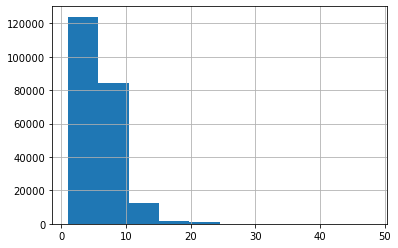

In [10]:
### add features to be consistent with test set of row in trip, and total trips in trip

df["row_num"] = df.groupby("utrip_id")["checkin"].rank(ascending=True,pct=False).astype(int)
utrip_counts = df["utrip_id"].value_counts()
df["total_rows"] = df["utrip_id"].map(utrip_counts)

### last step in trip
df["last"] = (df["total_rows"]==df["row_num"]).astype(int)
print(df[["row_num","total_rows"]].describe())

df["total_rows"].hist(); 

### replace rare categorical variable(s) - affiliates
* replace rare variables (under 2 occurrences) with "-1" dummy

In [11]:
### replace rare variables (under 2 occurrences) with "-1" dummy

affiliates_counts = df["affiliate_id"].value_counts()
print("before:", affiliates_counts)
print("uniques",df["affiliate_id"].nunique())
affiliates_counts = affiliates_counts.to_dict()
# df["affiliate_id"] = df["affiliate_id"].where(df["affiliate_id"].apply(lambda x: x.map(x.value_counts()))>=3, -1)
df["affiliate_id"] = df["affiliate_id"].where(df["affiliate_id"].map(affiliates_counts)>=3, -2)
df["affiliate_id"] = df["affiliate_id"].astype(int)

print("after\n",df["affiliate_id"].value_counts())
print("uniques",df["affiliate_id"].nunique())

before: 9924    53075
359     33238
384     16955
9452    16316
4541     8089
        ...  
5080        1
6617        1
6361        1
2139        1
4094        1
Name: affiliate_id, Length: 1655, dtype: int64
uniques 1655
after
 9924    53075
359     33238
384     16955
9452    16316
4541     8089
        ...  
8632        3
7871        3
6078        3
1760        3
4395        3
Name: affiliate_id, Length: 1016, dtype: int64
uniques 1016


In [12]:
# df["total_rows"].map(pd.cut(df["total_rows"],bins=3,))

#### Create pseudo ID for use with CF - composed of semi-distinct tuple of variables
* should have moderate uniqueness. Main purpose is to get good embeddings for those variables 

* `'device_class','affiliate_id', 'booker_country','checkin_quarter'` - 14K "uniques"
* `'device_class','affiliate_id', 'booker_country'` - 7.5 K "uniques"

In [13]:
### for possible "user id" embedding/ID : How many unique values are there for these source tuple? :
### Could also maybe add previous location/lag1 country/city ? 
## 'device_class','affiliate_id', 'booker_country' - 7.5 K "uniques"
## 'device_class','affiliate_id', 'booker_country','checkin_month' - 24 K "uniques"
## 'device_class','affiliate_id', 'booker_country','checkin_quarter' 14K "uniques"
## ,"total_rows" 

print(df[ID_COLS + ['checkin_month',"total_rows"]].nunique(axis=0))
df.groupby(ID_COLS).size()

# id2 = [item for item in ID_COLS if item != "last"]
# df.groupby(id2).size()

device_class          3
affiliate_id       1016
booker_country        5
checkin_quarter       4
last                  2
checkin_month        12
total_rows           29
dtype: int64


device_class  affiliate_id  booker_country  checkin_quarter  last
0             -2            0               2                0        3
                                            3                0        7
                                                             1        2
                                            4                0       11
                                                             1        2
                                                                     ..
2              10613        2               4                0        2
               10615        1               2                0        2
                                            3                0        7
                                                             1        1
               10668        2               1                0        1
Length: 8083, dtype: int64

In [14]:
# df["ID"] = df['device_class'].astype(str)+"_"+df['affiliate_id'].astype(str)\
# +"_"+df['booker_country'].astype(str)+"_"+df['checkin_quarter'].astype(str)

df["ID"] = df[ID_COLS].astype(str).sum(1)#.astype("category")

# df["ID"] = df["ID"].astype("category")
print(df["ID"].tail(3))
print(df["ID"].nunique())

180789    19452120
180790    19452120
180791    19452121
Name: ID, dtype: object
8083


### keep seperate DF of IDs and component features - will make merging id feats simpler later

In [15]:
df_ID = df[["ID"]+ID_COLS].drop_duplicates().set_index("ID")
df_ID

,device_class,affiliate_id,booker_country,checkin_quarter,last
ID,,,,,
09924430,0,9924,4,3,0
09924431,0,9924,4,3,1
03417410,0,3417,4,1,0
05583411,0,5583,4,1,1
07974440,0,7974,4,4,0
...,...,...,...,...,...
07063131,0,7063,1,3,1
07652210,0,7652,2,1,0
05939340,0,5939,3,4,0


* Continue

In [16]:
##### Following aggregation features - would be best to use time window (sort data) to generate, otherwise they will LEAK! (e.g. nunique countries visited)

### count features (can also later add rank inside groups).
### Some may be leaks (# visits in a trip should use time window?) , and do users repeat? 
### can add more counts of group X time period (e.g. affiliate X month of year)

## alt way to get counts/freq :

if GET_COUNT_AGG_FEATS:
    count_cols = [ 'city_id','affiliate_id', 'booker_country', 'hotel_country', 
    #               'utrip_id','user_id', 
     "checkin_month","checkin_week"]
    for c in count_cols:
        df[f"{c}_count"] = df.groupby([c])["duration"].transform("size")

    ########################################################
    ## nunique per trip
    ### https://stackoverflow.com/questions/46470743/how-to-efficiently-compute-a-rolling-unique-count-in-a-pandas-time-series

    nunique_cols = [ 'city_id','affiliate_id', 'booker_country', 'hotel_country']
    # df["nunique_booker_countries"] = df.groupby("utrip_id")["booker_country"].nunique()
    # df["nunique_hotel_country"] = df.groupby("utrip_id")["hotel_country"].nunique()
    for c in nunique_cols:
        df[f"{c}_nunique"] = df.groupby(["utrip_id"])[c].transform("nunique")
    print(df.nunique())

    ########################################################
    ## get frequency/count feature's rank within a group - e.g. within a country (or affiliate) 
    ## add "_count" to column name to get count col name, then add rank col 

    ### ALT/ duplicate feat - add percent rank (instead or in addition)

    rank_cols = ['city_id','affiliate_id', 'booker_country','hotel_country',
     "checkin_month"]
    ### what is meaning of groupby and rank of smae variable by same var? Surely should be 1 / unary? 
    for c in rank_cols:
        df[f"{c}_rank_by_hotel_country"] = df.groupby(['hotel_country'])[f"{c}_count"].transform("rank")
        df[f"{c}_rank_by_booker_country"] = df.groupby(['booker_country'])[f"{c}_count"].transform("rank")
        df[f"{c}_rank_by_affiliate"] = df.groupby(['affiliate_id'])[f"{c}_count"].transform("rank")     
else:
    freq = df["city_id"].value_counts()
    df["city_id_count"] = df["city_id"].map(freq)
    print(df["city_id_count"].describe())
    
df

count    223456.000000
mean        322.684314
std         488.074165
min           1.000000
25%          17.000000
50%         101.000000
75%         381.000000
max        2226.000000
Name: city_id_count, dtype: float64


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,checkin_week,checkin_month,checkin_quarter,checkin_month_sin,checkin_month_cos,utrip_steps_from_end,row_num,total_rows,last,ID,city_id_count
117277,136,2016-09-20,2016-09-22,52933,0,9924,4,105,136_4,38,9,3,-0.866025,-5.000000e-01,0.142857,1,7,0,09924430,232
117278,136,2016-09-22,2016-09-23,51685,0,9924,4,105,136_4,38,9,3,-0.866025,-5.000000e-01,0.285714,2,7,0,09924430,71
117279,136,2016-09-23,2016-09-24,43323,0,9924,4,105,136_4,38,9,3,-0.866025,-5.000000e-01,0.428571,3,7,0,09924430,11
117280,136,2016-09-24,2016-09-26,55990,0,9924,4,105,136_4,38,9,3,-0.866025,-5.000000e-01,0.571429,4,7,0,09924430,32
117281,136,2016-09-26,2016-09-27,46411,0,9924,4,105,136_4,39,9,3,-0.866025,-5.000000e-01,0.714286,5,7,0,09924430,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64260,6257973,2016-08-12,2016-08-15,15470,2,5755,2,119,6257973_1,32,8,3,-0.500000,-8.660254e-01,1.000000,4,4,1,25755231,69
180788,6258041,2016-04-28,2016-04-29,57109,1,9452,1,55,6258041_1,17,4,2,1.000000,6.123234e-17,0.250000,1,4,0,19452120,13
180789,6258041,2016-04-29,2016-04-30,57109,1,9452,1,55,6258041_1,17,4,2,1.000000,6.123234e-17,0.500000,2,4,0,19452120,13
180790,6258041,2016-04-30,2016-05-01,7529,1,9452,1,55,6258041_1,17,4,2,1.000000,6.123234e-17,0.750000,3,4,0,19452120,3


In [17]:
df.loc[df["city_id_count"]>=7]["city_id"].nunique()

3944

In [18]:
assert df.isna().sum().max() ==0

In [19]:
# df2 = df[["user_id","city_id"]].drop_duplicates().copy()
df2 = df.drop_duplicates(subset=["user_id","city_id"])["city_id"].copy()
print(df2.shape[0])
print("df2 nunique (cities without duplicate user visits)",df2.nunique())

# c2_counts = df2["city_id"].value_counts()
c2_counts = df2.value_counts()
# df2["new_counts"] = df2["city_id"].map(c2_counts)
# df2["new_counts"] = df2.map(c2_counts)
print("city counts")
print(c2_counts)
print(c2_counts.describe())
print("cities with at least 3:",(c2_counts>=3).sum())
print("cities with at least 7:",(c2_counts>=7).sum())
print("cities with at least 15:",(c2_counts>=15).sum())
print("cities with at least 30:",(c2_counts>=30).sum())
print("cities with at least 100:",(c2_counts>=100).sum())
print("cities with at least 300:",(c2_counts>=300).sum())

c2_freq = df2.value_counts(normalize=True)
print("top 4 sum coverage (normalized): ",c2_freq[0:4].sum().round(3))
print("top 50 sum coverage (normalized): ",c2_freq[0:50].sum().round(3))
print("top 100 sum coverage (normalized): ",c2_freq[0:100].sum().round(3))
print("top 400 sum coverage (normalized): ",c2_freq[0:400].sum().round(3))
print("top 1,000 sum coverage (normalized): ",c2_freq[0:1000].sum().round(3))
print("top 5,000 sum coverage (normalized): ",c2_freq[0:5000].sum().round(3))
print("top 8,000 sum coverage (normalized): ",c2_freq[0:8000].sum().round(3))

197722
df2 nunique (cities without duplicate user visits) 21238
city counts
23921    1589
47499    1458
55128    1362
64876    1284
29319    1250
         ... 
49444       1
2237        1
188         1
32126       1
6147        1
Name: city_id, Length: 21238, dtype: int64
count    21238.000000
mean         9.309822
std         45.507467
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1589.000000
Name: city_id, dtype: float64
cities with at least 3: 7870
cities with at least 7: 3734
cities with at least 15: 1944
cities with at least 30: 1109
cities with at least 100: 335
cities with at least 300: 78
top 4 sum coverage (normalized):  0.029
top 50 sum coverage (normalized):  0.184
top 100 sum coverage (normalized):  0.264
top 400 sum coverage (normalized):  0.48
top 1,000 sum coverage (normalized):  0.641
top 5,000 sum coverage (normalized):  0.865
top 8,000 sum coverage (normalized):  0.916


## Frequent city target List + City count encoding
* Get the K most frequent target city IDs - selected based on frequency as final destination (not just overall)
* +- Also after this, replace rare city IDs categorical features with count encoding to reduce dimensionality
    * Keep them as count, or aggregate all of them as "under_K"?

##### Output  : `TOP_TARGETS` - filter data by this *after* creation of lag features ! 

* Drop duplicates by the same user (reduce possible bias of frequent users? Only relevant if test is seperater from "frequent travellers") 
    * results in 216,633 , vs 217,686 without dropping duplicates by users
    * ~19.9k unique cities
    
* Could do other encodings - https://contrib.scikit-learn.org/category_encoders/count.html

* Note that all this is after we've added rank, count features beforehand, so that information won't be lost for these variables, despite these transforms



* **NOTE** he most frequent final destinations are NOT the same as the most popular overall destinations +- first location ! 

In [20]:
if KEEP_TOP_K_TARGETS > 0 :
    df_end = df.loc[df["utrip_steps_from_end"]==1].drop_duplicates(subset=["city_id","hotel_country","user_id"])[["city_id","hotel_country"]].copy()
    print(df_end.shape[0])
    end_city_counts = df_end.city_id.value_counts()
    print(end_city_counts)
    
    TOP_TARGETS = end_city_counts.head(KEEP_TOP_K_TARGETS).index.values
    print(f"top {KEEP_TOP_K_TARGETS} targets \n",TOP_TARGETS)
    
#     assert df.loc[df["city_id"].isin(TOP_TARGETS)]["city_id"].nunique() == KEEP_TOP_K_TARGETS

####        
# replace low frequency categoircal features    

# ##replace with count encoding if have at least k, group rarest as "-1":# df[BASE_CAT_COLS] = df[BASE_CAT_COLS].where(df[BASE_CAT_COLS].apply(lambda x: x.map(x.value_counts()))>=LOW_COUNT_THRESH, -1)   
# ## replace/group only the rare variables : 
# df[BASE_CAT_COLS] = df[BASE_CAT_COLS].where(df[BASE_CAT_COLS].apply(lambda x: x.map(x.value_counts()))>=LOW_COUNT_THRESH, -1)
# df[BASE_CAT_COLS].head()

##### Long tail of targets warning!
* 75% of cities appear less than 4 times in the data (as a final destination!) 
    * Dropping them will mean a maximum accuracy of 25% at best!!
    * training on intermediates may help overcome improve this. 
* Using ~2d step+ , still leaves us with 75% appearing less than 7 times

* Top 4,000 cities (just for those as final trip destination) - offers 89% coverage - 

* Unsure how to handle this - too amny targets to learn, and no auxiliary data to help learn it? 

In [21]:
# # df_end.city_id.value_counts(normalize=True)[0:4000].sum().round(3)# 4k: 89% coverage  (note, this is just for the end count cities, not all cities overall)

# df_end.city_id.value_counts(normalize=True)[0:2000].sum().round(3) #7k: 97% coverage

### Filter data by city id frequency
#### df2 - smaller df (may not ben ecessary to make

* drop rows if it's city id appears less than X times - this is prior to CF
* We could also add inclusion/exclusion based on target appearing/frequency as target in final stage of rtip - optional
* maybe also drop (end exclude in freq counting) thefirst point in a trip ? 



In [22]:
### unsure about this filtering - depends if data points are real or mistake
print("dropping users with less than 4 trips")
df2 = df.loc[df["total_rows"]>=4].copy()
print("abnormal users dropped",df.shape[0]-df2.shape[0])

print(f"dropping cities with less than {MIN_TARGET_FREQ} occurences:")
df2 = df2.loc[df2.groupby(["city_id"])["hotel_country"].transform("count")>=MIN_TARGET_FREQ] ## update count
# df2 = df2.loc[df2["city_id_count"]>=MIN_TARGET_FREQ]

print(df2.shape[0])

print("nunique cities after freq filt",df2["city_id"].nunique())
print("nunique city_id per hotel_country:")
df2.groupby(["hotel_country"])["city_id"].nunique().describe()

dropping users with less than 4 trips
abnormal users dropped 386
dropping cities with less than 40 occurences:
145035
nunique cities after freq filt 914
nunique city_id per hotel_country:


count     78.000000
mean      11.717949
std       18.890592
min        1.000000
25%        1.250000
50%        5.000000
75%       12.750000
max      118.000000
Name: city_id, dtype: float64

In [23]:
# LAG_FEAT_COLS = ['city_id', 'device_class',
#        'affiliate_id', 'booker_country', 'hotel_country', 
#        'duration', 'same_country']

In [24]:
# ### lag features - last n visits
# groupbyLagFeatures(df=df2.head(20), # .set_index(["checkin","checkout","user_id"])
#                    lag=[1,2],group="utrip_id",lag_feature_cols=LAG_FEAT_COLS)

#### get a DF of all cities per country
* +- get from original DF, +- remove cities that appear less than 4? times , and countries with less than 4 hotels? (Or keep - to avoid messing up training?)
* Weighted Sample from it, for negatives, +- most freq by country/affiliate/etc
* Don't drop duplicates by user, keep orig freq? 

In [25]:
# df_cities = df[["city_id","hotel_country","city_id_count"]] ## +- drop duplicates by tripid? 
df_cities = df2[["city_id","hotel_country","city_id_count"]].drop_duplicates().sort_values(["city_id_count","city_id"],ascending=False).head(9123)
# print(df_cities.nunique())
# df_cities = df_cities.loc[df_cities.groupby("hotel_country")["city_id"].transform("nunique")>4]
# df_cities = df_cities.loc[df_cities["city_id_count"]>=10].sort_values("city_id_count",ascending=False)
print(df_cities.nunique())
print(df_cities.shape[0])
df_cities

# ### 5 most frequent overall
# df_city_samples = df_cities.drop_duplicates().sort_values("city_id_count",ascending=False).groupby("city_id").head(5) 
# df_city_samples

city_id          914
hotel_country     78
city_id_count    291
dtype: int64
914


,city_id,hotel_country,city_id_count
179186,47499,71,2226
211121,23921,34,2043
138117,36063,56,1838
222070,17013,21,1746
162153,29319,34,1593
...,...,...,...
171047,15564,93,40
100018,14378,56,40
183141,14197,49,40
11330,12445,56,40


In [26]:
df_cities.city_id_count.describe()

count     914.000000
mean      158.959519
std       229.407856
min        40.000000
25%        56.000000
50%        84.000000
75%       159.750000
max      2226.000000
Name: city_id_count, dtype: float64

### add lag features + Train/test/data split
* Lag feats (remember for categorical)
* Drop leak features (target values - country, city)

* drop instances  that lack history (e.g. at least 3d step and onwards) - by dropna in lag feat
* fill nans
* Split train/test by `user id` / split could maybe be by `utrip ID` ? ? 
    * Test - only last trip
    *  stratified train/test split by class - then drop any train rows with overlap with tests' IDs.  
        * Could also stratify by users, but risks some classes being non present in test
        
###### Big possible improvement to lag features: Have "first location" (starting point) "lag" feature

In [27]:
### features to drop - not usable, or leaks (e.g. aggregations on target)

TARGET_COL = 'city_id'
# DROP_FEATS = ['user_id',
#     'checkin', 'checkout',
#               'hotel_country','city_id_count','same_country',
#               'utrip_id',
# #               'utrip_steps_from_end',
#              'city_id_count','hotel_country_count',
#               'city_id_nunique', 'hotel_country_nunique',
#               'city_id_rank_by_hotel_country','city_id_rank_by_booker_country', 'city_id_rank_by_affiliate',
#               'affiliate_id_rank_by_hotel_country','affiliate_id_rank_by_booker_country', 'affiliate_id_rank_by_affiliate',
#               'hotel_country_rank_by_hotel_country',
#        'hotel_country_rank_by_booker_country','hotel_country_rank_by_affiliate',
#               'booker_country_rank_by_hotel_country','booker_country_rank_by_booker_country',
#               'checkin_month_rank_by_hotel_country',
#              ]

# df2.drop(DROP_FEATS,axis=1).columns

TODO: 
* we will want later to split also by user/`utrip_Id`...  - add that ot variables

* We may want to keep the count of the targets - for explicit reccomenders (i.e frequncy of an id visiting some location) - could use to augment feature matrix, e.g. with svd

In [28]:
## n ote - we will want later to split also by user/utrip Id... 
print(MF_KEEP_COLS)
print(df2.shape)
df2 = df2[MF_KEEP_COLS]
print("IDs:",df2["ID"].nunique())
## for now - drop duplicates/frequency info. (could keeo as count ?)
df2 = df2.drop_duplicates()
print("drop duplicates after subset of variables shape:",df2.shape)
print("unique cities:",df2["city_id"].nunique())
# print("positives targets/cities per id\n",df2.groupby("ID"))
df2

['ID', 'device_class', 'affiliate_id', 'booker_country', 'checkin_quarter', 'last', 'city_id', 'hotel_country']
(145035, 20)
IDs: 6639
drop duplicates after subset of variables shape: (78034, 8)
unique cities: 914


,ID,device_class,affiliate_id,booker_country,checkin_quarter,last,city_id,hotel_country
117277,09924430,0,9924,4,3,0,52933,105
117278,09924430,0,9924,4,3,0,51685,105
117281,09924430,0,9924,4,3,0,46411,105
117283,09924431,0,9924,4,3,1,41113,105
117410,03417410,0,3417,4,1,0,10485,71
...,...,...,...,...,...,...,...,...
58380,07974420,0,7974,4,2,0,31870,49
98848,09924430,0,9924,4,3,0,43329,34
98850,09924430,0,9924,4,3,0,8359,34
98854,23631440,2,3631,4,4,0,58413,34


In [29]:
df2.groupby("ID",observed=True).size().describe()

count    6639.000000
mean       11.753879
std        42.553760
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       716.000000
dtype: float64

In [30]:
cities_per_id = df2.groupby("ID",observed=True)["city_id"].nunique() ## if we don't user observed = True, we'd get all combinations counted #.transform("nunique")
print("cities_per_id")
cities_per_id.describe()

cities_per_id


count    6639.000000
mean       11.753879
std        42.553760
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       716.000000
Name: city_id, dtype: float64

##### 

### join DF with negatives of all possible, filtered city/county combinations
* Note that this will yield a **LOT** of rows - with lots of sparsity (vast majority are 0)
* Ideally - we would sample from a sparse user-item cooccurrence, or sample from scratch with every epoch. But that's hard. 
    * If sampling - we should be sure to keep the most frequent/popular overall. e.g. sample 1k + 10 most popular ? 
    
    
* Cartesian product ? https://stackoverflow.com/questions/13269890/cartesian-product-in-pandas
    * https://stackoverflow.com/questions/34161978/pandas-two-dataframe-cross-join
    
* This would be **MUCH** more effecient with a sparse matrix ("user-item cooccurrence"), and we could even apply SVD directly to a spars ematrix - but it is harder to use TF/keras on such a matrix, without a special generator. 

* I will downsample the result randomly, keeping all positives, and downsampling negatives per "ID", to a given ratio.

"Any input passed containing Categorical data will have all of its categories included in the cross-tabulation, even if the actual data does not contain any instances of a particular category."
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html


USe crosstab, stack/unstack, with categorical - 
https://stackoverflow.com/questions/57385009/pandas-groupby-observed-parameter-with-multiple-categoricals

In [31]:
# %%time
### (on subset) 2 million rows, mean target: 1.7%
"""
df2.groupby(["ID","city_id"],observed=False,dropna=False)["target"].count().fillna(0).astype(int).reset_index().describe()

# df2.groupby(["ID","city_id"],observed=True,dropna=False)["target"].count().reset_index().describe()
"""

'\ndf2.groupby(["ID","city_id"],observed=False,dropna=False)["target"].count().fillna(0).astype(int).reset_index().describe()\n\n# df2.groupby(["ID","city_id"],observed=True,dropna=False)["target"].count().reset_index().describe()\n'

In [32]:
%%time
### all combinations - slow, outputs all combinations, 3d column ["0"] is sum/count 
## solution from : https://stackoverflow.com/questions/57385009/pandas-groupby-observed-parameter-with-multiple-categoricals

df_interactions = pd.crosstab(df2["ID"],df2["city_id"]).stack().reset_index()
df_interactions.rename(columns={0:"target"},inplace=True)

print(df_interactions.describe())
# df_interactions.loc[df_interactions.iloc[:,2]>0].describe()
df_interactions["target"] = df_interactions["target"].clip(upper=1)
df_interactions

            city_id        target
count  6.068046e+06  6.068046e+06
mean   3.290268e+04  1.285982e-02
std    1.938140e+04  1.126697e-01
min    3.900000e+01  0.000000e+00
25%    1.599000e+04  0.000000e+00
50%    3.172400e+04  0.000000e+00
75%    4.896800e+04  0.000000e+00
max    6.736500e+04  1.000000e+00
Wall time: 1.87 s


,ID,city_id,target
0,0-2030,39,0
1,0-2030,55,0
2,0-2030,343,0
3,0-2030,382,0
4,0-2030,657,0
...,...,...,...
6068041,29970441,67307,0
6068042,29970441,67334,0
6068043,29970441,67353,0
6068044,29970441,67361,0


#### save intermediate results to disk + add id feats
* all interactions (after the filtering, befoer class wise subsampling)
* also join with categoircal feats

* jion with subset of most popular cities + sample from other cities

In [33]:
df_interactions = df_interactions.join(df_ID,on="ID")
df_interactions

#save to disk
if SAVE_TO_DISK:
    df_interactions.to_csv("interactions_filtered_raw.csv.gz",index=False,compression="gzip")

In [34]:
df_cities_top = df_cities.head(99).drop(["city_id_count"],axis=1) ## top K most popular cities
df_cities_bottom = df_cities[99:].drop(["city_id_count"],axis=1) ## all remainign cities

* Subsample training data by class and group
* Afterwards, join with individual variables (per id, and also city to country)

* Note that we're taking negatives only from our target subset here, and aren't addressing frequency either...
    * Approach would be best if we resampled many times (per epoch?)   to improve coverage 

* NOTE: Currently missing any split by user, or final stage in trip level! 
* May leak to train like this.. !

In [35]:
round(100*df_interactions["target"].mean(),3)

1.286

In [36]:
df_interactions.loc[df_interactions["target"]==1].groupby('ID',observed=True).size().describe() #.sample(frac=.3) 

count    6639.000000
mean       11.753879
std        42.553760
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       716.000000
dtype: float64

In [37]:
df_interactions.loc[df_interactions["target"]==0].groupby('ID',observed=True).size().describe() #.sample(frac=.3) 

count    6639.000000
mean      902.246121
std        42.553760
min       198.000000
25%       909.000000
50%       912.000000
75%       913.000000
max       913.000000
dtype: float64

In [38]:
df_interactions.loc[df_interactions["target"]==0].shape[0]

5990012

In [39]:
%%time
NEGATIVES_DOWNSAMPLE_FRAC = 0.1

### guarantee K most popular destinations are included if in negatives: 
df_neg1 = df_interactions.loc[df_interactions["target"]==0].merge(df_cities_top,on="city_id",how="inner")

### sample randomly k or % interactions per "ID": 
df_neg2 = df_interactions.loc[df_interactions["target"]==0].merge(df_cities_bottom,on="city_id",how="inner")
df_neg2 = df_neg2.groupby("ID",observed=True).sample(frac=NEGATIVES_DOWNSAMPLE_FRAC)
# df_neg2

### I do not htink there is a need to add a downsample specifically for "last"==1 (since we keep all the positives anyway)

Wall time: 8.93 s


In [40]:
assert df_interactions.loc[df_interactions["target"]==1].isna().sum().max() ==0

In [41]:
df_feat = pd.concat([df_interactions.loc[df_interactions["target"]==1].merge(df_cities[["city_id","hotel_country"]],on="city_id",how="inner"),
                    df_neg1,df_neg2],ignore_index=True).drop_duplicates().sample(frac=1)
del df_neg1,df_neg2

print("target mean %:",round(100*df_feat["target"].mean(),3))

assert df_feat.isna().sum().max()==0
# df_feat.dropna(how="any",inplace=True,axis=0)
assert df_feat.drop_duplicates(["ID","city_id"]).shape[0] == df_feat.shape[0]

## for some reason, affilaite id gets turned into a float, fix this: 
assert df_feat["affiliate_id"].nunique() == df_feat["affiliate_id"].astype(int).nunique()
df["affiliate_id"] = df["affiliate_id"].astype(int)

## if doing quarter as embedding instead of continous :
# assert df_feat["checkin_quarter"].nunique() == df_feat["checkin_quarter"].astype(int).nunique()
# df["checkin_quarter"] = df["checkin_quarter"].astype(int)

### save intermediate result to disk
if SAVE_TO_DISK:
    df_feat.to_csv("interactions_filtered_train.csv.gz",index=False,compression="gzip")

df_feat

target mean %: 6.269


,ID,city_id,target,device_class,affiliate_id,booker_country,checkin_quarter,last,hotel_country
684984,02418410,65322,0,0,2418,4,1,0,34
891217,05243411,23798,0,0,5243,4,1,1,81
172255,14132130,8766,0,1,4132,1,3,0,109
1206220,24797210,27695,0,2,4797,2,1,0,73
85055,01601230,382,0,0,1601,2,3,0,49
...,...,...,...,...,...,...,...,...,...
623948,09420330,60143,0,0,9420,3,3,0,109
188432,03417431,10485,0,0,3417,4,3,1,71
293390,110332421,21328,0,1,10332,4,2,1,34
479041,166340,47486,0,1,66,3,4,0,64


In [42]:
print("dropping ID")
df_feat.drop("ID",axis=1,inplace=True,errors="ignore")

dropping ID


### city ID encoder & other features ordinal encoder
* Encode city id into integer range with label_encoder
* This will make embedding more effecient 
* IMPORTANT: We will need to map back using this encoder, in order to get original IDs. 

* We do it at this step, since we've dropped so many targets beforehand. We could do this as first step in pipeline as well ! 

* I do this also for the other categorical variables. For them we don't save the transformer since we don't care about reversing ? 
     * **WARNING**: Check this doesn't mess things when predicting on new data !!!  

In [43]:
CAT_COLS_LIST = ['device_class', 'affiliate_id', 'booker_country']

# print(df_feat["city_id"].min())
# df_feat["city_id"]

In [44]:
city_encoder = LabelEncoder().fit(df_feat["city_id"])
country_encoder = LabelEncoder().fit(df_feat["hotel_country"]) 

df_feat["city_id"] = city_encoder.transform(df_feat["city_id"])
df_feat["hotel_country"] = country_encoder.transform(df_feat["hotel_country"])

In [45]:
print(df_feat[CAT_COLS_LIST].describe())
categories_ordinal_encoder = OrdinalEncoder(dtype=np.int64)
categories_ordinal_encoder.fit(df_feat[CAT_COLS_LIST])
df_feat[CAT_COLS_LIST] = categories_ordinal_encoder.transform(df_feat[CAT_COLS_LIST])
print(df_feat[CAT_COLS_LIST].describe())

       device_class  affiliate_id  booker_country
count  1.244710e+06  1.244710e+06    1.244710e+06
mean   5.203574e-01  5.187693e+03    2.242218e+00
std    7.222074e-01  3.247364e+03    1.197902e+00
min    0.000000e+00 -2.000000e+00    0.000000e+00
25%    0.000000e+00  2.436000e+03    1.000000e+00
50%    0.000000e+00  4.886000e+03    2.000000e+00
75%    1.000000e+00  8.072000e+03    3.000000e+00
max    2.000000e+00  1.069700e+04    4.000000e+00
       device_class  affiliate_id  booker_country
count  1.244710e+06  1.244710e+06    1.244710e+06
mean   5.203574e-01  4.877547e+02    2.242218e+00
std    7.222074e-01  2.931817e+02    1.197902e+00
min    0.000000e+00  0.000000e+00    0.000000e+00
25%    0.000000e+00  2.360000e+02    1.000000e+00
50%    0.000000e+00  4.700000e+02    2.000000e+00
75%    1.000000e+00  7.500000e+02    3.000000e+00
max    2.000000e+00  9.790000e+02    4.000000e+00


#### Artifical train/test split grouping 

* Make additional grouping for train/test split.
WARNING: This is NOT as good/reliable as splitting by USER_ID or utripID, but we do this for now, since we don't have that variable here
* This splitting would result in some variables not being learned ? 

* Ignore some of the ID columns for this groups creation
    * warning - manua/fragile/may break if columns used change
    
This splitting is **not reliable**!! It is just to try to approximate something like splitting across trips

* Mainly - groups should include rows with last 0/1 for same trip
    * How bad is it that we group/exclude by city_id (for a specific grouping)  ?? 
    * Alt - could do group also with lag1_city_id ? (If using that)

In [46]:
df_feat.columns

Index(['city_id', 'target', 'device_class', 'affiliate_id', 'booker_country',
       'checkin_quarter', 'last', 'hotel_country'],
      dtype='object')

In [47]:
df_feat["Group_id"] = df_feat[['city_id', 'device_class', 'affiliate_id', 'booker_country',
       'checkin_quarter']].astype(str).sum(1)
print(df_feat["Group_id"].nunique())

1006342


In [48]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.25, n_splits=2, random_state = 7).split(df_feat, groups=df_feat['Group_id']))

train = df_feat.iloc[train_inds].drop("Group_id",axis=1)
test = df_feat.iloc[test_inds]

## split test into validation and final test (only last stage of trip). We could also spliut by group here as well

valid_inds, test_inds  = next(GroupShuffleSplit(test_size=.6, n_splits=2, random_state = 7).split(test, groups=test['Group_id']))
valid = test.iloc[valid_inds].drop("Group_id",axis=1)
test = test.iloc[test_inds].drop("Group_id",axis=1)
test = test.loc[test["last"]==1]

print("train",train.shape[0],"valid",valid.shape[0],"test",test.shape[0])

train 933721 valid 124624 test 68058


In [49]:
train

,city_id,target,device_class,affiliate_id,booker_country,checkin_quarter,last,hotel_country
172255,121,0,1,398,1,3,0,53
823241,721,0,0,343,3,4,0,2
762024,863,0,0,183,1,3,1,63
650046,840,0,1,30,1,1,0,5
1077487,264,0,1,321,2,4,0,27
...,...,...,...,...,...,...,...,...
623948,817,0,0,854,3,3,0,53
188432,143,0,0,339,4,3,1,34
293390,298,0,1,948,4,2,1,20
479041,664,0,1,6,3,4,0,31


In [50]:
train["city_id"].describe()

count    933721.000000
mean        460.103505
std         271.148202
min           0.000000
25%         234.000000
50%         448.000000
75%         705.000000
max         913.000000
Name: city_id, dtype: float64

In [51]:
# print(df2.shape)
# # ### lag features - last n visits
# df_feat = groupbyLagFeatures(df=df2.copy(), 
#                    lag=[1],group="utrip_id",lag_feature_cols=LAG_FEAT_COLS)
# df_feat = df_feat.dropna(subset=["lag3_city_id"]).sample(frac=1)

### filter for only trip targets that are among the K most popular :

# df_feat = df_feat.drop(DROP_FEATS,axis=1,errors="ignore")
# print(df_feat.shape)


In [52]:
### filter for most frequent targets

if KEEP_TOP_K_TARGETS > 0 :
    print(df_feat.shape[0])
    df_feat = df_feat.loc[df_feat["city_id"].isin(TOP_TARGETS)]
    print(df_feat.shape[0])    
    assert df_feat["city_id"].nunique() == KEEP_TOP_K_TARGETS

In [53]:
# ########################
# ## stratified train/test split by class - then drop any train rows with overlap wit htest IDs.  Could also stratify by users, but risks some classes being non present in test
# ### split could maybe be by utrip ID ? 
# ### orig - split by group : 

# # train_inds, test_inds = next(GroupShuffleSplit(test_size=.2, n_splits=2, random_state = 7).split(df_feat, groups=df_feat['user_id']))
# # X_train = df_feat.iloc[train_inds].drop(DROP_FEATS,axis=1,errors="ignore")
# # X_test = df_feat.iloc[test_inds].drop(DROP_FEATS,axis=1,errors="ignore")
# # assert (set(X_train[TARGET_COL].unique()) == set(X_test[TARGET_COL].unique()))
# #################
# ## alt: split by class. May be leaky! 
# X_train, X_test = train_test_split(df_feat,stratify=df_feat[TARGET_COL])

# ########################
# print("X_train",X_train.shape[0])
# ## get last row in trip only in test/eval set: 
# print("X_test",X_test.shape[0])

# ### following is for splitting by group - can't do so currebntly as group/user id col is missing
# # X_test = X_test.loc[X_test["utrip_steps_from_end"]==1] # last row per trip
# # print("X_test after filtering for last instance per trip",X_test.shape[0])

# # y_train = X_train.pop(TARGET_COL)
# # y_test = X_test.pop(TARGET_COL)

# # print("# classes",y_train.nunique())

# # # ## check that same classes in train and test - 
# # # assert (set(y_train.unique()) == set(y_test.unique()))

## Model
* For now - simple multiclass model (Tabnet? LSTM?) ; +- subsample - only most frequent classes/cities

    * Tabnet: `pip install pytorch-tabnet`
        * https://github.com/dreamquark-ai/tabnet/blob/develop/forest_example.ipynb
    * TensorFlow Tabmet: https://github.com/ostamand/tensorflow-tabnet/blob/master/examples/train_mnist.py

* split train/test by groups
    * Test - only last trip. 


* Preprocess for TF/keras + dot product, emebddings etc'

* categoircal + embedding example : 
    * https://www.tensorflow.org/tutorials/structured_data/feature_columns
    * https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_identity
    
    
* Shared embeddings (for use of lag1 city, country id : https://www.tensorflow.org/api_docs/python/tf/feature_column/shared_embeddings

### Add tf feature columns
* https://www.tensorflow.org/tutorials/structured_data/feature_columns#choose_which_columns_to_use
* Assumes use of a tf.data pipeline  (`df_to_dataset`)

In [101]:
train_ds = df_to_dataset(train, shuffle=False, batch_size=256)
val_ds = df_to_dataset(valid, shuffle=False, batch_size=512)
test_ds = df_to_dataset(test, shuffle=False, batch_size=512)
val_ds

<BatchDataset shapes: ({city_id: (None,), device_class: (None,), affiliate_id: (None,), booker_country: (None,), checkin_quarter: (None,), last: (None,), hotel_country: (None,)}, (None,)), types: ({city_id: tf.int64, device_class: tf.int64, affiliate_id: tf.int64, booker_country: tf.int64, checkin_quarter: tf.int64, last: tf.int32, hotel_country: tf.int64}, tf.int64)>

In [102]:
CAT_COLS_LIST + ["city_id","hotel_country"]

['device_class', 'affiliate_id', 'booker_country', 'city_id', 'hotel_country']

In [103]:
feature_columns = []

# numeric cols
for header in ['checkin_quarter',"last"]:
    feature_columns.append(feature_column.numeric_column(header))
    
# Categorical cols ("generic") & embedding (We could use strings here instead of numbers - https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list
# embedding columns
for col_name in CAT_COLS_LIST + ["city_id","hotel_country"]:
    print(col_name)
    # breed1 = feature_column.categorical_column_with_vocabulary_list(
    #       'Breed1', dataframe.Breed1.unique())
    c_uniques = df_feat[col_name].nunique()
    categorical_column = feature_column.categorical_column_with_identity(
        col_name, c_uniques)
    col_embedding = feature_column.embedding_column(categorical_column, dimension=min(c_uniques//2,50))
    feature_columns.append(col_embedding)
    

# # indicator_columns - do one hot encoding - maybe instead of embedding ?? 
indicator_column_names = ["device_class"] ## "booker_country",
for col_name in indicator_column_names:
#     categorical_column = feature_column.categorical_column_with_vocabulary_list(
#         col_name, dataframe[col_name].unique())
    categorical_column = feature_column.categorical_column_with_identity(
        col_name, df_feat[col_name].nunique())
    
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

    
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

device_class
affiliate_id
booker_country
city_id
hotel_country


In [104]:
valid

,city_id,target,device_class,affiliate_id,booker_country,checkin_quarter,last,hotel_country
1206220,399,0,2,460,2,1,0,36
85055,3,0,0,167,2,3,0,25
911040,88,0,0,566,4,4,1,33
1080541,656,0,1,346,2,3,1,18
174923,130,0,0,218,4,2,1,34
...,...,...,...,...,...,...,...,...
523497,690,0,1,760,3,1,0,58
169509,121,0,0,433,2,3,0,53
1162911,795,0,1,874,2,1,1,20
260908,262,0,0,913,4,3,1,7


In [105]:
feature_columns

[NumericColumn(key='checkin_quarter', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='last', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='device_class', number_buckets=3, default_value=None), dimension=1, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002A99D806808>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='affiliate_id', number_buckets=980, default_value=None), dimension=50, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002A99D89F6C8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='booker_coun

* Todo : how to get dot product(s) between the inputs? 


https://stackoverflow.com/questions/54375298/how-to-use-tensorflow-feature-columns-as-input-to-a-keras-model

https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b

* https://www.tensorflow.org/tutorials/load_data/csv#mixed_data_types

* https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding  - without using `tf.feature_column`

In [106]:
## set output bias for better initial guesses / class imbalance : 
## https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias
output_bias = tf.keras.initializers.Constant(np.log([train["target"].mean()]))

In [107]:
#### FC model, without the dot product

# model = tf.keras.Sequential([
#   feature_layer,
# #   layers.Dense(128, activation='elu'),
# #     layers.Dropout(.2),
#   layers.Dense(64, activation='relu'),
#   layers.Dropout(.1),
#   layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
# ])

# model.compile(optimizer='adam',
#               loss="binary_crossentropy", #tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy',"AUC","Recall","Precision"]) # 'accuracy', ,tf.keras.metrics.TopKCategoricalAccuracy(4) - not used in ranking


# model.fit(train_ds,
#           validation_data=val_ds,
#           epochs=max_epochs)

In [108]:
### https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b

# feature_layer.get_config()

In [109]:
# https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

def get_keras_dataset(df):
    X = {str(col) : np.array(df[col]) for col in df.columns}
    return X


get_keras_dataset(valid)

{'city_id': array([399,   3,  88, ..., 795, 262, 553], dtype=int64),
 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'device_class': array([2, 0, 0, ..., 1, 0, 0], dtype=int64),
 'affiliate_id': array([460, 167, 566, ..., 874, 913, 316], dtype=int64),
 'booker_country': array([2, 2, 4, ..., 2, 4, 2], dtype=int64),
 'checkin_quarter': array([1, 3, 4, ..., 1, 3, 3], dtype=int64),
 'last': array([0, 0, 1, ..., 1, 1, 1]),
 'hotel_country': array([36, 25, 33, ..., 20,  7, 28], dtype=int64)}

In [110]:
train

,city_id,target,device_class,affiliate_id,booker_country,checkin_quarter,last,hotel_country
172255,121,0,1,398,1,3,0,53
823241,721,0,0,343,3,4,0,2
762024,863,0,0,183,1,3,1,63
650046,840,0,1,30,1,1,0,5
1077487,264,0,1,321,2,4,0,27
...,...,...,...,...,...,...,...,...
623948,817,0,0,854,3,3,0,53
188432,143,0,0,339,4,3,1,34
293390,298,0,1,948,4,2,1,20
479041,664,0,1,6,3,4,0,31


In [111]:
train.columns

Index(['city_id', 'target', 'device_class', 'affiliate_id', 'booker_country',
       'checkin_quarter', 'last', 'hotel_country'],
      dtype='object')

In [113]:
(df_feat.nunique()+1)//2

city_id               457
target                  1
device_class            2
affiliate_id          490
booker_country          3
checkin_quarter         2
last                    1
hotel_country          39
Group_id           503171
dtype: int64

In [138]:
## based on:  https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding
cat_inputs = []
num_inputs = []
embeddings = []
embedding_layer_names = []
# emb_n = 57
CITY_EMB_DIM = 57 # dimensions for hotel_country embedding - limited by user level variables
HOTEL_COUNTRY_EMB_DIM = 7 # dimensions for hotel_country embedding - limited by subset of user level variables

numeric_cols = ["last"] ## "checkin_quarter"

categorical_cols_user = ['device_class', 'booker_country',"checkin_quarter", 'affiliate_id'] # , 'affiliate_id'
categorical_cols_item = ['city_id', 'hotel_country']
categorical_cols = categorical_cols_item + categorical_cols_user 


## Embedding for categorical, "X" features (vs "targets") - do items first for easy selection. Do twice, to control embed sizes for dot product
for col in categorical_cols_item[0:1]: # city only
    _input = layers.Input(shape=[1], name=col)    
    c_uniques = df_feat[col].nunique()
    _embed = layers.Embedding(df_feat[col].max() + 1, CITY_EMB_DIM, name=col+'_emb')(_input)
    cat_inputs.append(_input)
    embeddings.append(_embed) 
    embedding_layer_names.append(col+'_emb')
for col in categorical_cols_item[1:2]: # hotel_country only only
    _input = layers.Input(shape=[1], name=col)    
    c_uniques = df_feat[col].nunique()
    _embed = layers.Embedding(df_feat[col].max() + 1, HOTEL_COUNTRY_EMB_DIM, name=col+'_emb')(_input)
    cat_inputs.append(_input)
    embeddings.append(_embed) 
    embedding_layer_names.append(col+'_emb')
    
    
for col in categorical_cols_user:
    _input = layers.Input(shape=[1], name=col)    
    c_uniques = df_feat[col].nunique()
    _embed = layers.Embedding(df_feat[col].max() + 1, min((c_uniques+1)//2,50), name=col+'_emb')(_input)
    cat_inputs.append(_input)
    embeddings.append(_embed) 
    embedding_layer_names.append(col+'_emb')## doesn't seem to be used? 
    
# Simple inputs for the numeric features
for col in numeric_cols:
    numeric_input = layers.Input(shape=(1,), name=col)
    num_inputs.append(numeric_input)
   
    
# # Merge the numeric inputs
# merged_num_inputs = layers.concatenate(num_inputs)

#numeric_dense = layers.Dense(20, activation='relu')(merged_num_inputs)

### try to get just user, and just item embeddings cincated seperately. Based on input order

# target_inputs =  layers.concatenate(embeddings[0:2])

### TODO - concat with numerics also
user_inputs =  layers.concatenate(embeddings[2:])
# user_inputs =  layers.concatenate([embeddings[2:],num_inputs]) ### I currently couldn't get the concat working!! 

# dot_score = layers.Dot(axes=(2))([target_inputs,user_inputs]) ## meantto be used on all users X all item (city+country)

dot_score_city1 = layers.Dot(axes=(2),normalize=False)([embeddings[0],user_inputs])
dot_score_country1 = layers.Dot(axes=(2),normalize=False)([embeddings[1],layers.concatenate(embeddings[2:-1])])

# # Merge embedding and use a Droput to prevent overfittting
merged_inputs = layers.concatenate(embeddings)
# # spatial_dropout = layers.SpatialDropout1D(0.2)(merged_inputs)
# flat_embed = layers.Flatten()(merged_inputs)#(spatial_dropout)

# # Merge embedding and numeric features
# all_features = layers.concatenate([flat_embed, merged_num_inputs])

# all_features = layers.concatenate([dot_score, merged_num_inputs])

# x = layers.concatenate([dot_score_city1,dot_score_country1]) # for just dot product model
x = layers.concatenate([merged_inputs,dot_score_city1,dot_score_country1])

# MLP for classification
# x = layers.Dropout(0.2)(layers.Dense(128, activation='relu')(all_features))
x = layers.Dropout(0.1)(layers.Dense(128, activation='relu')(x))
x = layers.Dropout(0.1)(layers.Dense(64, activation='relu')(x))

# Final model
output = layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(x)
model = models.Model(inputs=cat_inputs + num_inputs, outputs=output)


model.compile(optimizer='adam', loss="binary_crossentropy", 
              metrics=['accuracy',"AUC"]) #,"Precision""Recall", 'accuracy', ,tf.keras.metrics.TopKCategoricalAccuracy(4) - not used in ranking

model.summary()

model.fit(train_ds,
          validation_data=val_ds,
          epochs=max_epochs)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
device_class (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
booker_country (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
checkin_quarter (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
affiliate_id (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

* After 4 epochs (1.23k sampled data - only dot product model + embeddings (no FC), 4 epochs
    * loss: 0.1380 - accuracy: 0.9503 - auc: 0.9185 - val_loss: 0.1426 - val_accuracy: 0.9492 - val_auc: 0.9104
    
* Above + sigmoid bias, + 128 elu FC last layer, 20% dropout: 
    * 12s 3ms/step - loss: 0.1255 - accuracy: 0.9539 - auc: 0.9362 - val_loss: 0.1421 - val_accuracy: 0.9519 - val_auc: 0.9084
* Above + sigmoid bias, + 64 + 128 elu FC last layer, 10% dropout:     
    * 13s 4ms/step - loss: 0.1150 - accuracy: 0.9586 - auc: 0.9456 - val_loss: 0.1409 - val_accuracy: 0.9540 - val_auc: 0.9078
* (directly) above, + relu (instead of elu):
    * 14s 4ms/step - loss: 0.1100 - accuracy: 0.9601 - auc: 0.9515 - val_loss: 0.1367 - val_accuracy: 0.9568 - val_auc: 0.9152
    
* (directly) above,(relu) + normalize Dot product:
    * 13s 4ms/step - loss: 0.1060 - accuracy: 0.9605 - auc: 0.9564 - val_loss: 0.1372 - val_accuracy: 0.9564 - val_auc: 0.9119
    * Normalizing seems to be the same or overfit by an iota? 

In [115]:
user_inputs

<KerasTensor: shape=(None, 1, 57) dtype=float32 (created by layer 'concatenate_19')>

In [117]:
embeddings

[<KerasTensor: shape=(None, 1, 57) dtype=float32 (created by layer 'city_id_emb')>,
 <KerasTensor: shape=(None, 1, 7) dtype=float32 (created by layer 'hotel_country_emb')>,
 <KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'device_class_emb')>,
 <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'booker_country_emb')>,
 <KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'checkin_quarter_emb')>,
 <KerasTensor: shape=(None, 1, 50) dtype=float32 (created by layer 'affiliate_id_emb')>]

In [119]:
embeddings[0]

<KerasTensor: shape=(None, 1, 57) dtype=float32 (created by layer 'city_id_emb')>

In [120]:
user_inputs

<KerasTensor: shape=(None, 1, 57) dtype=float32 (created by layer 'concatenate_19')>

In [121]:
embeddings[2:]

[<KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'device_class_emb')>,
 <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'booker_country_emb')>,
 <KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'checkin_quarter_emb')>,
 <KerasTensor: shape=(None, 1, 50) dtype=float32 (created by layer 'affiliate_id_emb')>]

In [122]:
num_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'last')>]

### Evaluation: 
* don't enable shuffle on the tf_ds, or results will be scrambled.

In [128]:
# y_val_preds_proba = model.predict(val_ds)
# print(roc_auc_score(y_true = valid["target"],y_score=y_val_preds_proba[:,0,0]))

0.9108393699884039


In [132]:
y_test_preds_proba = model.predict(test_ds)
print(round(100*roc_auc_score(y_true = test["target"],y_score=y_test_preds_proba[:,0,0]),2))

# classification_report

91.48


In [ ]:
# CAT_FEAT_NAMES = ["booker_country", "device_class","affiliate_id",
# #                   "user_id", ## ? could use lower dim - depends on train/test overlap
#                   "checkin_week","checkout_week",
#                     "checkin_weekday",
#     "lag1_city_id","lag1_booker_country","lag1_hotel_country","lag1_affiliate_id", "lag1_device_class",
#      "lag2_city_id","lag2_booker_country","lag2_hotel_country","lag2_affiliate_id","lag2_device_class",
#       "lag3_city_id","lag3_booker_country","lag3_hotel_country","lag3_affiliate_id","lag3_device_class",
#                  ]

In [ ]:
# NUMERIC_COLS = [item for item in list(df_feat.columns.drop(TARGET_COL))  if item not in CAT_FEAT_NAMES]
# print(len(NUMERIC_COLS))
# print("numeric cols",NUMERIC_COLS)

# for c in NUMERIC_COLS:
#     l_enc =   StandardScaler() # MinMaxScaler()#
#     l_enc.fit(df_feat[c].values.reshape(-1,1))
#     X_train[c] = l_enc.transform(X_train[c].values.reshape(-1,1))
#     X_test[c] = l_enc.transform(X_test[c].values.reshape(-1,1))
    
# for c in CAT_FEAT_NAMES:
#     l_enc = LabelEncoder().fit(df_feat[c])
#     X_train[c] = l_enc.transform(X_train[c])
#     X_test[c] = l_enc.transform(X_test[c])

In [ ]:
# print("sum top4 total percentage:",y_train.value_counts(normalize=True)[0:4].sum().round(3))
# y_train.value_counts(normalize=True).round(5)

#### feature importance & evaluation
* Look for leaks!
* May be bug with ordering of results - evaluation doesn't make sense. Note that diff # outputs/classes, likely culprit

In [ ]:
# print("y_test nunique classes",y_test.nunique())
# y_test